In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
import pandas as pd


from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

from scipy import stats
import os
from efficacy_scripts import *




In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
from sklearn.preprocessing import scale

In [4]:
from detect_intermediates import *
from interpret_tICs import *

In [5]:
from msmbuilder.utils import verbosedump, verboseload

In [6]:
import multiprocessing as mp
print(mp.cpu_count())

12


In [7]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

150


<AsyncMapResult: chdir>

In [9]:
wiki_mor_df_file = "/home/enf/md_simulations/MOR/docking/wiki_mor_df_sush.csv"
full_ligand_df = pd.read_csv(wiki_mor_df_file, header=0)
full_ligand_df.name = [n.lower().strip().replace(" ", "_").replace("β", "beta").replace("α", "alpha").replace("Α", "alpha") for n in full_ligand_df.name.values]
full_ligand_df.index = full_ligand_df.name

full_ligand_df.index = full_ligand_df.name
full_ligand_df["source"] = "wikipedia"

full_ligand_df = add_smiles_column(full_ligand_df, names=full_ligand_df.index, cids=None, sids=None, binding_db=None,
                                                worker_pool=None, parallel=True)
agonist_df = full_ligand_df

In [10]:
curated_agonists = agonist_df.loc[(agonist_df["Edits"] == "agonist") | (agonist_df["Edits"] == "Agonist")].index.values.tolist()
curated_antagonists = agonist_df.loc[(agonist_df["Edits"] == "antagonist") | (agonist_df["Edits"] == "Antagonist")].index.values.tolist()

In [11]:
curated_agonists

['7-pet',
 'acetylfentanyl',
 'acetylmethadol',
 'acrylfentanyl',
 'adrenorphin',
 'ah-7921',
 'alfentanil',
 'alimadol',
 '3-allylfentanyl',
 'allylnorpethidine',
 'allylprodine',
 'alphacetylmethadol',
 'alphamethadol',
 'alphamethylthiofentanyl',
 'anileridine',
 'azaprocin',
 'azidomorphine',
 'bdpc',
 'benzethidine',
 'betacetylmethadol',
 'betahydroxyfentanyl',
 'betahydroxythiofentanyl',
 'betamethadol',
 'bezitramide',
 'brifentanil',
 'bromadoline',
 'butyrfentanyl',
 'c-8813',
 'carfentanil',
 'cebranopadol',
 'chloromorphide',
 'chloroxymorphamine',
 'ciprefadol',
 'clonitazene',
 'dadle',
 'damgo',
 'dermorphin',
 'desmethylprodine',
 'desomorphine',
 'dextromoramide',
 'dextropropoxyphene',
 'diampromide',
 'difenoxin',
 'dihydroetorphine',
 'dihydromorphine',
 'dimenoxadol',
 'dimepheptanol',
 'dimethylaminopivalophenone',
 'dioxaphetyl_butyrate',
 'diphenoxylate',
 'dipipanone',
 'dpi-3290',
 'eluxadoline',
 '6,14-endoethenotetrahydrooripavine',
 'endomorphin',
 'endomor

In [12]:
full_ligand_df["ligand"] = full_ligand_df["name"]

In [362]:
wiki_mor_df_file = "/home/enf/md_simulations/MOR/docking/wiki_mor_df.pkl"
with open(wiki_mor_df_file, "wb") as f:
    pickle.dump(full_ligand_df, f)

In [13]:
wiki_mor_df_file = "/home/enf/md_simulations/MOR/docking/wiki_mor_df.pkl"
with open(wiki_mor_df_file, "rb") as f:
    full_ligand_df = pickle.load(f)

In [191]:
#drugbank_duds = pd.read_csv("/home/enf/md_simulations/MOR/docking/drugbank_no_MOR.csv")
#cids = convert_names_to_cids(drugbank_duds["CAS Number"].values.tolist(), worker_pool=None, parallel=True)
#cids = [n for n in cids if n is not None]
#dud_cids = ["CID_%d" %c for c in cids]
#dud_df = pd.DataFrame(list(zip(["dud" for d in cids], dud_cids)), columns=["action", "name"], index=dud_cids)

aid_ligands = pd.read_csv("/home/enf/md_simulations/MOR/docking/AID_274396_data.csv")
aid_ligands = aid_ligands.loc[aid_ligands["PUBCHEM_ACTIVITY_OUTCOME"] == "Active"]
aid_ligands["CID"] = [int(c) for c in aid_ligands.PUBCHEM_CID.values]
aid_cids = ["CID_%d" %c for c in aid_ligands.CID.values]
aid_df = pd.DataFrame(list(zip(["antagonist" for a in aid_cids], aid_cids)), columns=["action", "name"], index=aid_cids)
aid_df["source"] = "pubchem"
aid_df["assay"] = "AID_274396"

full_ligand_df = pd.concat([full_ligand_df, aid_df], axis=0)
curated_agonist_df = pd.concat([full_ligand_df.loc[curated_agonists + curated_antagonists], aid_df], axis=0)

In [ ]:
curated_agonist_df["acti"]

In [54]:
agonist_df_file = "/home/enf/md_simulations/MOR/docking/full_agonist_df.pkl"
agonist_df = full_ligand_df.copy()
with open(agonist_df_file, "wb") as f:
    pickle.dump(agonist_df, f)

In [14]:
agonist_df_file = "/home/enf/md_simulations/MOR/docking/full_agonist_df.pkl"
with open(agonist_df_file, "rb") as f:
    agonist_df = pickle.load(f)

In [192]:
agonist_df_file = "/home/enf/md_simulations/MOR/docking/curated_agonist_df.pkl"
with open(agonist_df_file, "wb") as f:
    pickle.dump(curated_agonist_df, f)

In [15]:
agonist_df_file = "/home/enf/md_simulations/MOR/docking/curated_agonist_df.pkl"
with open(agonist_df_file, "rb") as f:
    curated_agonist_df = pickle.load(f)

In [ ]:
ligands_dir = "/home/enf/md_simulations/MOR/docking/ligands/32-stereoisomers_6-ring-conf"
ligand_df_file = "/home/enf/md_simulations/MOR/docking/Machine_Learning_Sush_10.9.2016-edited.xlsx"
ligand_df = pd.read_excel(ligand_df_file, index_col=0)
sk_compounds = ["compd0%d" %i for i in range(1,10)] + ["compd%d" %i for i in range(10, 110)]
#for i, comp in enumerate(sk_compounds):
#    if comp in [n.lower() for n in docked_compounds]:
#        new_name = ligand_df["Opiates/Opioids"].values[i].lower()
#        old_index[old_index.index(comp)] = comp
#full_docking_df.index = old_index

ligand_df["ligand"] = [str(n).lower().strip() for n in ligand_df["Opiates/Opioids"].values.tolist()]
ligand_df["action"] = [str(n).lower().strip() for n in ligand_df["Unnamed: 7"]]
ligand_df["MOR"] = ligand_df["MOR"].convert_objects(convert_numeric=True)
ligand_df = ligand_df.iloc[0:ligand_df.shape[0]-1]
ligand_df.index = sk_compounds
sk_ligand_df =  ligand_df[np.isfinite(ligand_df['MOR'].values.astype(float))]
smiles_list = convert_sdfs_to_smiles(["%s/%s.mol" %(ligands_dir, n) for n in sk_ligand_df.index.values.tolist()], parallel=True, worker_pool=None)
sk_ligand_df["smiles"] = smiles_list
sk_ligand_df = sk_ligand_df.loc[sk_ligand_df.smiles != ""]


In [ ]:
sk_ligand_df = sk_ligand_df.loc[sk_ligand_df["MOR"].dropna().index]

In [ ]:
-np.log10(sk_ligand_df["MOR"].values) + 9

array([  8.88941029,   8.93930216,   8.47625353,   8.33724217,
        10.67778071,  10.43179828,   8.92445304,  10.46852108,
        10.05551733,   9.39394125,  10.26272782,   9.9423339 ,
         9.23657201,   8.57511836,   6.63827216,   7.43179828,
         9.09691001,   9.07572071,   9.95860731,   9.01322827,
         9.65757732,   9.69897   ,   9.        ,   7.76955108,
         7.53165267,   7.98716278,   7.67571754,   8.56383735,
         7.56863624,   7.60205999,  10.        ,   6.23807216,
         6.17717835,   9.7212464 ,   8.02960663,   8.39469495,
         9.74472749,   7.71896663,   8.13667714,   8.29499204,
         9.13076828,   8.90135627,   8.97061622,   9.72815839,
         8.92738252,   9.04837111,   9.537602  ,   9.18045606,
         9.07058107,   9.13548892,   8.97142875,   8.69250396,
        10.48148606,   7.98046832,   7.24412514,   8.07058107,
         7.85387196,   8.11918641,   8.42829117,   8.4828041 ,
         6.68402965,   7.38933984,   7.24412514,   7.63

In [ ]:
sk_ligand_df["PCHEMBL_VALUE"] = 0.
sk_ligand_df["PCHEMBL_VALUE"] = -np.log10(sk_ligand_df["MOR"].values) + 9

In [ ]:
expanded_agonist_df = pd.concat([agonist_df, sk_ligand_df.loc[sk_ligand_df.action == "agonist"]], axis=0)
expanded_agonist_df = pd.concat([expanded_agonist_df, sk_ligand_df.loc[sk_ligand_df.action == "antagonist"]], axis=0)

In [22]:
chembl_df = pd.read_excel("/home/enf/md_simulations/MOR/docking/chembl_ki.xlsx", header=0, index_col=0)#.set_index("CMPD_CHEMBLID")
#chembl_df = pd.read_excel("/home/enf/md_simulations/MOR/docking/chembl_ec50.xlsx", header=0, index_col=0)#.set_index("CMPD_CHEMBLID")

print(chembl_df.shape)
chembl_df["smiles"] = chembl_df["CANONICAL_SMILES"]
compounds = convert_smiles_to_compounds(chembl_df["smiles"].values.tolist(), parallel=False, worker_pool=dview)
chembl_df["CID"] = [c[3] for c in compounds]
chembl_df["ligand"] = chembl_df.index
chembl_df["ligand"].loc[chembl_df["CID"] != ""] = ["CID_%d" %cid for cid in chembl_df.loc[chembl_df["CID"] != ""]["CID"].values.tolist()]

#write_smiles_files(chembl_df, "/home/enf/md_simulations/MOR/docking/ligands/32-stereoisomers_6-ring-conf")
#write_smiles_files(chembl_df, "/home/enf/md_simulations/MOR/docking/ligands")


#undone_ligands = list(set(chembl_df.loc[chembl_df["CID"] == ""].index.values.tolist() +  [n for n in chembl_cid_names if n not in get_ligands("/home/enf/b2ar_analysis/all_ligands/32-stereoisomers_6-ring-conf", ".sdf")]))

#print(len(chembl_cids))
#print(len(undone_ligands))

(4679, 58)


,MOLREGNO,PARENT_CMPD_CHEMBLID,PARENT_MOLREGNO,MOL_PREF_NAME,COMPOUND_KEY,MOLWEIGHT,ALOGP,PSA,NUM_RO5_VIOLATIONS,CANONICAL_SMILES,...,YEAR,VOLUME,ISSUE,FIRST_PAGE,CELL_ID,CELL_CHEMBL_ID,CELL_NAME,smiles,CID,ligand
CMPD_CHEMBLID,,,,,,,,,,,,,,,,,,,,,
CHEMBL1790045,1153676,CHEMBL1790045,1153676,NaN,1e (MCL-117),281.39,4.64,23.47,0.0,Oc1ccc2C[C@@H]3[C@@H]4CCCC[C@]4(CCN3CC#C)c2c1,...,2006.0,49.0,1.0,256.0,449.0,CHEMBL3308072,CHO,Oc1ccc2C[C@@H]3[C@@H]4CCCC[C@]4(CCN3CC#C)c2c1,6602241,CID_6602241
CHEMBL2334776,1524429,CHEMBL2334776,1524429,NaN,11,650.77,3.33,183.64,2.0,Cc1cc(O)cc(C)c1C[C@H](N)C(=O)N2CC[C@H](C2)C(=O...,...,2013.0,56.0,7.0,3102.0,722.0,CHEMBL3307715,HEK293,Cc1cc(O)cc(C)c1C[C@H](N)C(=O)N2CC[C@H](C2)C(=O...,,CHEMBL2334776
CHEMBL2334772,1524425,CHEMBL2334772,1524425,NaN,7,651.75,1.78,177.84,2.0,Cc1cc(O)cc(C)c1C[C@H](N)C(=O)N2CCC[C@H]2C(=O)N...,...,2013.0,56.0,7.0,3102.0,722.0,CHEMBL3307715,HEK293,Cc1cc(O)cc(C)c1C[C@H](N)C(=O)N2CCC[C@H]2C(=O)N...,,CHEMBL2334772
CHEMBL471243,521294,CHEMBL426084,324544,NaN,1,370.44,0.97,103.86,0.0,Cl.NC(=O)c1ccc2C[C@H]3N(CC4CC4)CC[C@@]5(CC(=O)...,...,2009.0,19.0,8.0,2289.0,449.0,CHEMBL3308072,CHO,Cl.NC(=O)c1ccc2C[C@H]3N(CC4CC4)CC[C@@]5(CC(=O)...,,CHEMBL471243
CHEMBL49269,73067,CHEMBL49269,73067,CYCLORPHAN,Cyclorphan,297.43,4.27,23.47,0.0,Oc1ccc2C[C@@H]3[C@@H]4CCCC[C@]4(CCN3CC5CC5)c2c1,...,2012.0,55.0,8.0,3878.0,449.0,CHEMBL3308072,CHO,Oc1ccc2C[C@@H]3[C@@H]4CCCC[C@]4(CCN3CC5CC5)c2c1,5359966,CID_5359966
CHEMBL49269,73067,CHEMBL49269,73067,CYCLORPHAN,(-)2a,297.43,4.27,23.47,0.0,Oc1ccc2C[C@@H]3[C@@H]4CCCC[C@]4(CCN3CC5CC5)c2c1,...,2007.0,17.0,6.0,1508.0,NaN,NaN,NaN,Oc1ccc2C[C@@H]3[C@@H]4CCCC[C@]4(CCN3CC5CC5)c2c1,5359966,CID_5359966
CHEMBL2347235,1529061,CHEMBL2347235,1529061,NaN,4,479.66,5.45,45.23,1.0,C[C@H]1C2Cc3ccc(cc3[C@@]1(C)CCN2CC4CC4)C(=O)NC...,...,2013.0,23.0,7.0,2128.0,NaN,NaN,NaN,C[C@H]1C2Cc3ccc(cc3[C@@]1(C)CCN2CC4CC4)C(=O)NC...,,CHEMBL2347235
CHEMBL19019,21459,CHEMBL19019,21459,NALTREXONE,Naltrexone,341.40,1.66,70.00,0.0,Oc1ccc2C[C@H]3N(CC4CC4)CC[C@@]56[C@@H](Oc1c25)...,...,2011.0,21.0,13.0,4001.0,449.0,CHEMBL3308072,CHO,Oc1ccc2C[C@H]3N(CC4CC4)CC[C@@]56[C@@H](Oc1c25)...,5360515,CID_5360515
CHEMBL495057,457021,CHEMBL495057,457021,NaN,14,497.58,3.25,94.92,0.0,Oc1ccc2C[C@H]3N(CC4CC4)CC[C@@]56[C@@H](Oc1c25)...,...,2009.0,52.0,5.0,1416.0,449.0,CHEMBL3308072,CHO,Oc1ccc2C[C@H]3N(CC4CC4)CC[C@@]56[C@@H](Oc1c25)...,,CHEMBL495057


(array([   3.,    4.,    3.,    3.,   11.,   20.,   25.,   38.,   60.,
          68.,   61.,   61.,   80.,   86.,  112.,   97.,  109.,  111.,
         106.,   86.,  125.,  103.,  112.,  102.,   97.,  137.,   90.,
          97.,  111.,  103.,   80.,  111.,   89.,   94.,   72.,   83.,
          80.,   72.,   56.,   72.,   72.,   52.,   27.,   22.,   21.,
           3.,    2.,    4.,    3.,    4.]),
 array([  4.13  ,   4.2674,   4.4048,   4.5422,   4.6796,   4.817 ,
          4.9544,   5.0918,   5.2292,   5.3666,   5.504 ,   5.6414,
          5.7788,   5.9162,   6.0536,   6.191 ,   6.3284,   6.4658,
          6.6032,   6.7406,   6.878 ,   7.0154,   7.1528,   7.2902,
          7.4276,   7.565 ,   7.7024,   7.8398,   7.9772,   8.1146,
          8.252 ,   8.3894,   8.5268,   8.6642,   8.8016,   8.939 ,
          9.0764,   9.2138,   9.3512,   9.4886,   9.626 ,   9.7634,
          9.9008,  10.0382,  10.1756,  10.313 ,  10.4504,  10.5878,
         10.7252,  10.8626,  11.    ]),
 <a list of 50 P

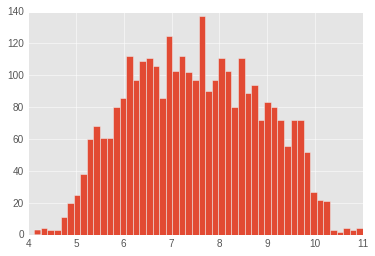

In [26]:
plt.hist(chembl_df["PCHEMBL_VALUE"].dropna().values, bins=50)

In [ ]:
plt.scatter(chembl_df["PCHEMBL_VALUE"].dropna().values, bins=50)

In [16]:
#with open("/home/enf/md_simulations/MOR/docking/chembl_ki_df.pkl", "wb") as f:
#    pickle.dump(chembl_df, f)

with open("/home/enf/md_simulations/MOR/docking/chembl_ki_df.pkl", "rb") as f:
    chembl_df = pickle.load(f)

In [17]:
list(set(chembl_df.index.values.tolist())).index("CHEMBL1256836")

ValueError: 'CHEMBL1256836' is not in list

In [19]:
df = chembl_df.copy()
print(df.shape)
c_maxes = df.groupby(df.index).PCHEMBL_VALUE.transform(max)
df = df[df.PCHEMBL_VALUE == c_maxes]
print(df.shape)
df = df.groupby(df.index).first()
print(df.shape)
#df = df.loc[df.CELL_NAME.dropna().index]
#df = df.loc[(df.CELL_NAME.str.contains("CHO")) | (df.CELL_NAME.str.contains("cho"))]
print(df.shape)
#df = df.loc[df["MOL_PREF_NAME"].dropna().index]
print(df.loc[df["PCHEMBL_VALUE"] < 8.].shape)
print(df.loc[df["PCHEMBL_VALUE"] > 8.].shape)
#df.loc[df["PCHEMBL_VALUE"] < 7.]

(4679, 61)
(2929, 61)
(2833, 61)
(2833, 61)
(1872, 61)
(945, 61)


(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([  9.14,   9.24,   9.34,   9.44,   9.54,   9.64,   9.74,   9.84,
          9.94,  10.04,  10.14]),
 <a list of 10 Patch objects>)

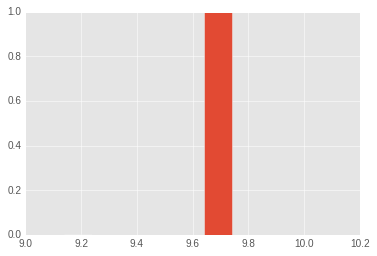

In [20]:
plt.hist(df.loc[df["MOL_PREF_NAME"] == "NALOXONE"].PCHEMBL_VALUE, bins=10)

(array([   9.,   15.,   61.,  134.,  154.,  230.,  245.,  227.,  253.,
         241.,  254.,  226.,  184.,  149.,  159.,  135.,  102.,   39.,
           7.,    9.]),
 array([  4.13  ,   4.4735,   4.817 ,   5.1605,   5.504 ,   5.8475,
          6.191 ,   6.5345,   6.878 ,   7.2215,   7.565 ,   7.9085,
          8.252 ,   8.5955,   8.939 ,   9.2825,   9.626 ,   9.9695,
         10.313 ,  10.6565,  11.    ]),
 <a list of 20 Patch objects>)

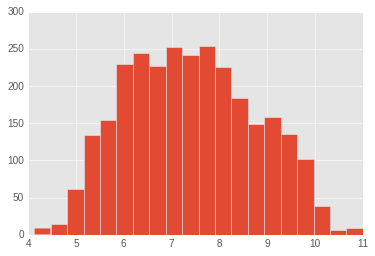

In [21]:
plt.hist(df.PCHEMBL_VALUE, bins=20)

In [26]:
full_ligand_df = chembl_df.copy()
sk_df = sk_ligand_df.copy()
sk_df.ligand = sk_df.index
full_ligand_df = pd.concat([full_ligand_df, sk_df], axis=0)


c_maxes = full_ligand_df.groupby(full_ligand_df.index).PCHEMBL_VALUE.transform(max)
full_ligand_df = full_ligand_df[full_ligand_df.PCHEMBL_VALUE == c_maxes]
print(full_ligand_df.shape)
full_ligand_df = full_ligand_df.groupby(full_ligand_df.index).first()
print(full_ligand_df.shape)
print(full_ligand_df.loc[full_ligand_df["PCHEMBL_VALUE"] < 8.].shape)

full_ligand_df = full_ligand_df.loc[full_ligand_df["PCHEMBL_VALUE"].dropna().index]

full_ligand_df.index = full_ligand_df.ligand
full_ligand_df.smiles = full_ligand_df.CANONICAL_SMILES
full_ligand_df = full_ligand_df.loc[full_ligand_df.smiles.dropna().index.values.tolist()]
full_ligand_df = full_ligand_df.groupby(full_ligand_df.index).first()


inactive_cutoff = 8.
active_cutoff = 8.

chembl_inactives = list(set(full_ligand_df.loc[full_ligand_df["ACTIVITY_COMMENT"].fillna('').str.contains("Not Active")].ligand.values.tolist() + full_ligand_df.loc[full_ligand_df["PCHEMBL_VALUE"] < inactive_cutoff].ligand.values.tolist()))
chembl_actives = full_ligand_df.loc[full_ligand_df["PCHEMBL_VALUE"] > active_cutoff].ligand.values.tolist()
intersection = set(chembl_inactives).intersection(set(chembl_actives))
chembl_inactives = list(set(chembl_inactives).difference(intersection))
chembl_actives = list(set(chembl_actives).difference(intersection))
full_ligand_df = full_ligand_df.loc[chembl_inactives + chembl_actives]

full_ligand_df["class"] = [0. for i in chembl_inactives] + [1. for j in chembl_actives]
full_ligand_df["activity"] = ["dud" for i in chembl_inactives] + ["binder" for j in chembl_actives]

#print(full_ligand_df.shape)
#print(len(chembl_inactives + chembl_actives))
full_ligand_df.index = [str(n).lower().strip().replace(" ", "_").replace("β", "beta").replace("α", "alpha").replace("Α", "alpha") for n in full_ligand_df.index]
#full_ligand_df.shape

(2929, 69)
(2833, 69)
(1872, 69)


In [27]:
curated_agonist_df["class"] = 1.
curated_agonist_df["activity"] = "binder"
full_affinity_df = pd.concat([full_ligand_df, curated_agonist_df], axis=0)

In [28]:
label_df_filename = "/home/enf/md_simulations/MOR/docking/labels_df_pIC50_8_8.pkl"
#if not os.path.exists(label_df_filename):
if 1==1:
    with open(label_df_filename, "wb") as f:
        pickle.dump(full_affinity_df, f, protocol=2)
#else:
#    with open(label_df_filename, "rb") as f:
#        full_ligand_df = pickle.load(f)

In [173]:
full_ligand_df.PCHEMBL_VALUE

cid_44430050      6.78
chembl3219940     5.45
chembl3665444     4.80
cid_10206324      5.89
chembl503367      6.92
cid_44430045      6.30
cid_10141332      6.63
cid_11391721      6.32
chembl2386894     6.78
chembl3596369     6.91
cid_44438974      6.25
chembl2112345     6.47
chembl2370996     5.35
chembl3084541     6.33
cid_3559          6.00
chembl3670294     4.92
chembl190600      6.06
cid_45486042      6.75
chembl1766033     6.89
chembl3319080     6.50
chembl246003      6.32
chembl108894      6.82
cid_44248791      6.18
chembl1818336     6.96
chembl3665440     6.11
chembl428276      5.29
cid_44574587      6.42
cid_441243        5.41
cid_68782313      5.89
chembl2369408     5.56
chembl3330666     6.27
cid_44413384      6.37
chembl261807      6.74
chembl350943      6.52
cid_9880          6.05
chembl1766029     6.74
chembl8072        5.12
cid_53326167      6.89
cid_25190607      6.85
cid_16665915      6.30
chembl568076      6.70
cid_10388166      4.67
cid_44600308      6.41
chembl33306

In [93]:
print(len(chembl_inactives))
print(len(chembl_actives))

1169
1640


In [46]:
ligand_dir = "/home/enf/md_simulations/MOR/docking/ligands/32-stereoisomers_6-ring-conf"
ligand_files = get_trajectory_files(ligand_dir, ".sdf") + get_trajectory_files(ligand_dir, ".mol")
ligand_files_clean = [n.split(".")[0].split("/")[-1].lower().strip() for n in ligand_files]
ligand_files_clean[100]

'cid_11979494'

In [47]:
#full_ligand_df = pd.concat([sk_ligand_df, full_ligand_df], axis=0)

In [48]:
full_ligand_df["smiles"] = ""
removed_ligands = []
sdf_files = []
sdf_ligands = []

for ligand in full_ligand_df.index:
    print(ligand)
    if (len(str(full_ligand_df["smiles"].loc[ligand])) > 4):
        continue
    else:
        try:
            sdf_file = ligand_files[ligand_files_clean.index(ligand.lower())]
            sdf_files.append(sdf_file)
            sdf_ligands.append(ligand)
        except:
            removed_ligands.append(ligand)

cid_5831
cid_7010
cid_11683
cid_6479523
cid_44430013
cid_91536
cid_5585
cid_4678
cid_2447
cid_2442
cid_44424838
cid_66265
cid_3899
cid_3039
cid_25190573
cid_1983
cid_2662
cid_2753
cid_10607
cid_5510
cid_6184351
cid_3767
cid_1720
cid_16574
cid_5193
cid_186907
cid_2712
cid_3883
cid_5090
cid_5284557
cid_54677971
cid_656665
cid_3168
cid_39147
cid_4098
cid_7014
cid_64715
cid_4114
cid_5546
cid_4499
cid_2160
chembl2367892
cid_5870
cid_3690
cid_7577
cid_5311067
cid_237
cid_702
cid_667550
cid_9812710
cid_5901
chembl555649
cid_57469
cid_6167
cid_54677470
cid_441140
cid_32798
cid_5281040
cid_2083
cid_60726
cid_443495
cid_5717
cid_3324
cid_2478
cid_3156
cid_5921
cid_3325
cid_4122
cid_5426
cid_2723949
cid_2052
cid_41867
cid_1645
cid_54683953
chembl407030
cid_60846
cid_667750
cid_53232
cid_4746
cid_2082
cid_441207
cid_5282379
cid_44093
cid_5944
cid_2477
cid_1935
cid_2435
chembl108417
cid_4911
cid_7516
cid_3108
cid_68911
cid_27447
cid_5340
cid_10531
cid_65016
cid_3902
cid_34001
cid_4828
cid_5144
cid_

In [49]:
smiles_list = convert_sdfs_to_smiles(sdf_files, parallel=True, worker_pool=None)
full_ligand_df["smiles"].loc[sdf_ligands] = smiles_list
#full_ligand_df = full_ligand_df.loc[[n for n in full_ligand_df.index.values if n not in removed_ligands]]

In [94]:
label_df_filename = "/home/enf/md_simulations/MOR/docking/labels_df_pIC50_7_7.pkl"
#if not os.path.exists(label_df_filename):
if 1==1:
    with open(label_df_filename, "wb") as f:
        pickle.dump(full_ligand_df, f, protocol=2)
#else:
#    with open(label_df_filename, "rb") as f:
#        full_ligand_df = pickle.load(f)

In [132]:
full_ligand_df.index

Index(['3-ho-pcp', '7-pet', 'acetorphine', 'acetoxyketobemidone',
       'acetyldihydrocodeine', 'acetylfentanyl', 'acetylmethadol',
       'acetylmorphone', 'acetylpropionylmorphine', 'acrylfentanyl',
       ...
       'CID_13109', 'CID_6439900', 'CID_9290', 'CID_9913767', 'CID_5284529',
       'CID_16684434', 'CID_67683363', 'CID_133017', 'CID_2993', 'CID_450601'],
      dtype='object', name='name', length=2171)

In [561]:
import os
reload(os)
ligand_df_file = "/home/enf/md_simulations/MOR/docking/Machine_Learning_Sush_10.9.2016-edited.xlsx"
ligand_df = pd.read_excel(ligand_df_file, index_col=0)
docked_compounds = [n for n in full_docking_df.index.values if "comp" in n.lower() or "mpd" in n.lower()]
old_index = full_docking_df.index.values.tolist()
old_index = [n.lower().strip() for n in old_index]
sk_compounds = ["compd0%d" %i for i in range(1,10)] + ["compd%d" %i for i in range(10, 110)]
#for i, comp in enumerate(sk_compounds):
#    if comp in [n.lower() for n in docked_compounds]:
#        new_name = ligand_df["Opiates/Opioids"].values[i].lower()
#        old_index[old_index.index(comp)] = comp
#full_docking_df.index = old_index

ligand_df["ligand"] = [str(n).lower().strip() for n in ligand_df["Opiates/Opioids"].values.tolist()]
ligand_df["action"] = [str(n).lower().strip() for n in ligand_df["Unnamed: 7"]]
ligand_df["MOR"] = ligand_df["MOR"].convert_objects(convert_numeric=True)
ligand_df = ligand_df.iloc[0:ligand_df.shape[0]-1]
ligand_df.index = sk_compounds
sk_ligand_df =  ligand_df[np.isfinite(ligand_df['MOR'].values.astype(float))]



In [278]:
"""conc_ligand_df = pd.concat([sk_ligand_df, web_ligand_df.loc[web_ligand_df["action"].str.contains("Antagonist")]], axis=0)
conc_ligand_df
"""

'conc_ligand_df = pd.concat([sk_ligand_df, web_ligand_df.loc[web_ligand_df["action"].str.contains("Antagonist")]], axis=0)\nconc_ligand_df\n'

In [279]:
print(full_docking_df.columns)
print(full_docking_df.shape)

Index(['Inactive Crystal', 'Active Crystal', 'State 0', 'State 10', 'State 11',
       'State 12', 'State 13', 'State 14', 'State 15', 'State 16', 'State 17',
       'State 18', 'State 19', 'State 1', 'State 20', 'State 21', 'State 22',
       'State 23', 'State 24', 'State 2', 'State 3', 'State 4', 'State 5',
       'State 6', 'State 7', 'State 8', 'State 9'],
      dtype='object')
(1104, 27)


In [27]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)

In [247]:
roc_auc_score(y_true.values, new_df.loc[y_true.index.values.tolist()].mean(axis=1).values)

0.77629133065077172

In [21]:
binding_db = pd.read_table("/home/enf/md_simulations/MOR/docking/BindingDB_ChEMBL.tsv", error_bad_lines=False)

b'Skipping line 528: expected 49 fields, saw 61\nSkipping line 529: expected 49 fields, saw 61\nSkipping line 530: expected 49 fields, saw 61\nSkipping line 531: expected 49 fields, saw 61\nSkipping line 532: expected 49 fields, saw 61\nSkipping line 533: expected 49 fields, saw 61\nSkipping line 534: expected 49 fields, saw 61\nSkipping line 535: expected 49 fields, saw 61\nSkipping line 536: expected 49 fields, saw 61\nSkipping line 537: expected 49 fields, saw 61\nSkipping line 538: expected 49 fields, saw 61\nSkipping line 539: expected 49 fields, saw 61\nSkipping line 540: expected 49 fields, saw 61\nSkipping line 541: expected 49 fields, saw 61\nSkipping line 542: expected 49 fields, saw 61\nSkipping line 543: expected 49 fields, saw 61\nSkipping line 544: expected 49 fields, saw 61\nSkipping line 545: expected 49 fields, saw 61\nSkipping line 546: expected 49 fields, saw 61\nSkipping line 547: expected 49 fields, saw 61\nSkipping line 548: expected 49 fields, saw 61\nSkipping li

In [40]:
with open("/home/enf/md_simulations/MOR/docking/binding_db.pkl", "wb") as f:
    pickle.dump(binding_db, f, protocol=2)

In [ ]:
binding_db.index = binding_db["ChEMBL ID of Ligand"][]

In [35]:
from importlib import reload
import grids
reload(grids)
from grids import *

In [ ]:
arrestin_df = ligand_df.loc[(~ligand_df["BioAssay Name"].str.contains("hetero")) & (~ligand_df["BioAssay Name"].str.contains("Counter"))]# & (ligand_df["BioAssay Name"].str.contains("GTP"))]
plt.hist(arrestin_df["AC Value (micromolar)"].dropna().values, bins=50)
plt.show()

In [ ]:
arrestin_df["AC Value (micromolar)"].dropna()